In [1]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 9, orientation = 45+22.5),
			utils.GaborKernel(9, 90+22.5),
			utils.GaborKernel(9, 135+22.5),
			utils.GaborKernel(9, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

In [2]:
def time_dim(input):
	return input.unsqueeze(0)

In [3]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.Grayscale(),
	transforms.ToTensor(),
    transforms.Resize(114),
	time_dim,
	filter,
	sf.pointwise_inhibition,
	utils.Intensity2Latency(number_of_spike_bins = 10, to_spike = True)])

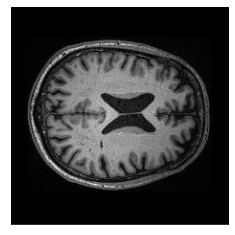

In [5]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

train = ImageFolder("/Users/taraapple/Downloads/center/120-170-5/train/")
test = ImageFolder("/Users/taraapple/Downloads/center/120-170-5/test/")
sample_idx = random.randint(0, len(train) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(train[sample_idx][0])
plt.show()

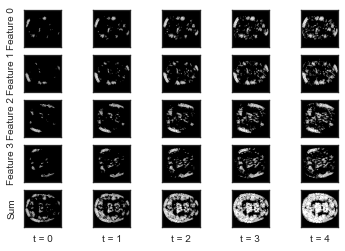

In [7]:
import numpy as np
train = ImageFolder("/Users/taraapple/Downloads/center/120-170-5/train/", transform)
test = ImageFolder("/Users/taraapple/Downloads/center/120-170-5/test/", transform) # adding transform to the dataset
plt.style.use('seaborn-white')
plt_idx = 0
sw = train[sample_idx][0]
for f in range(4):
	for t in range(5):
		plt_idx += 1
		ax = plt.subplot(5, 5, plt_idx)
		plt.setp(ax, xticklabels=[])
		plt.setp(ax, yticklabels=[])
		if t == 0:
			ax.set_ylabel('Feature ' + str(f))
		plt.imshow(sw[t,f].numpy(),cmap='gray')
		if f == 3:
			ax = plt.subplot(5, 5, plt_idx + 5)
			plt.setp(ax, xticklabels=[])
			plt.setp(ax, yticklabels=[])
			if t == 0:
				ax.set_ylabel('Sum')
			ax.set_xlabel('t = ' + str(t))
			plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

train = utils.CacheDataset(train)
test = utils.CacheDataset(test)
train_loader = DataLoader(train)
test_loader = DataLoader(test)

In [9]:
import SpykeTorch.snn as snn
pool = snn.Pooling(kernel_size = 7, stride = 2)

In [10]:
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30)

In [11]:
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

In [12]:
conv.reset_weight()
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

In [13]:
feature2class = [0] * 10 + [1] * 10
print(feature2class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
%%time
print("Starting Reinforcement Learning ...")
for iter in range(50):
	print('\rIteration:', iter, end="")
	for data,targets in train_loader:
		for x,t in zip(data, targets):
			x = pool(x)
			p = conv(x)
			o, p = sf.fire(p, 20, return_thresholded_potentials=True)
			winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
			if len(winners) != 0:
				if feature2class[winners[0][0]] == t:
					stdp(x, p, o, winners)
				else:
					anti_stdp(x, p, o, winners)
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 49
Reinforcement Learning is Done.
CPU times: user 1d 17h 28min 22s, sys: 27min 47s, total: 1d 17h 56min 10s
Wall time: 1d 17h 22min 35s


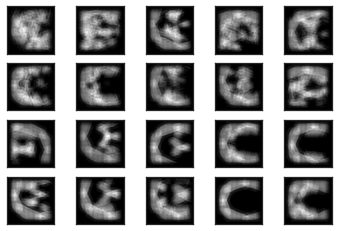

In [15]:
import SpykeTorch.visualization as vis
import torch
feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (9, 9), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

In [16]:
error = 0
silent = 0
total = 0
for data,targets in train_loader:
	for x,t in zip(data, targets):
		total += 1
		x = pool(x)
		p = conv(x)
		o, p = sf.fire(p, 20, return_thresholded_potentials=True)
		winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
		if len(winners) != 0:
			if feature2class[winners[0][0]] != t:
				error += 1
		else:
			silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.20741577263316394
Silent Samples: 0.0


In [17]:
error = 0
silent = 0
total = 0
for data,targets in test_loader:
	for x,t in zip(data, targets):
		total += 1
		x = pool(x)
		p = conv(x)
		o, p = sf.fire(p, 20, return_thresholded_potentials=True)
		winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
		if len(winners) != 0:
			if feature2class[winners[0][0]] != t:
				error += 1
		else:
			silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.23891810668670171
Silent Samples: 0.0
